# Optimal growth model using Time Iteration
This explanation is  my reminder and may have some mistakes.
- What is Time iteration?

This method uses Euler equation. What we do is the following step.
    1. guess tomorrow's policy function.
    2. find today's policy function given tomorrow's policy function.
    3. update guess and iterate until it converges.

- Consider Euler equation

$$u'(c) = \beta u'(c')[f'(k')+(1-\delta))]$$

- Use the resource constraint $c +k' = f(k) +(1-\delta)k$,

$$u'(f(k) +(1-\delta)k-k') =\beta u'(f(k')+(1-\delta)k' -k^{\prime\prime})[f'(k') +(1-\delta))]$$

We use today's capital grid and tomorrow's policy,p(k').

To implement policy function iteration, we have to use nonlinear solver and interpolation method.
    - nonlinear solver:fzero(Roots.jl)
    - interpolation: Piecewise linear interpolation(QuantEcon.jl)

## Time Iteration Algorithm

### set up the situation
1. set capital grid in this period.
2. guess initial tomorrow's policy
3. set error tolerance and maximum number of iteration

### Iteration 

For all values of today's capital grid, 

   solve Euler equation for optimal tomorrow's capital,k'.
   
   $$u'(f(k) +(1-\delta)k-k') =\beta u'\left(f(k')+(1-\delta)k' -p(k')\right)[f'(k') +(1-\delta)]$$
   
Then, approximate new policy $Tp$ by $\left\{K_j, K'_j \right\}$

Finally, We check convergence.

## Implementation

In [1]:
using Roots
using BenchmarkTools
using Plots
using QuantEcon
pyplot()

Plots.PyPlotBackend()

In [2]:
mutable struct TImodel{TI<:Integer,TF<:AbstractFloat}
    β::TF
    γ::TF
    δ::TF
    α::TF
    nk::TI
    kgrid::Array{TF,1}
    pguess::Array{TF,1}
    u::Function
    u′::Function
    f::Function
    f′::Function
end

function TIModel(β=0.95, # subjective discount factor
                  γ=2.0, # risk aversion
                  δ=0.1, # depriciation rate
                  α=0.33, # capital share
                  nk=250,# Number of grid point
                 )

    # create capital grid
    kstar=((1.0/β-(1.0-δ))/α)^(1.0/(α-1.0)) # compute steady state
    kmin = 0.1*kstar # minimal capital stock
    kmax = 2.0*kstar # maximal capital stock
    kgrid = collect(linspace(kmin,kmax,nk)) 
    
    # initial guess
    pguess = collect(linspace(kmin,kmax,nk)) 
    
    # utility function
    u(c) =(c^(1-γ))/(1-γ) 
    u′(c) = c^(-γ) 
    
    # production function
    f(k) =  k^α 
    f′(k) = α*k^(α-1) 
    
    
    if γ == 1.0
        u_log(c) = log(c)
        t = TImodel(β, γ,δ, α, nk, kgrid, pguess, u_log, u′, f, f′)
    else
        t = TImodel(β, γ,δ, α, nk, kgrid, pguess, u, u′, f, f′)
    end
    
end

TIModel (generic function with 6 methods)

In [3]:
t = TIModel()

TImodel{Int64,Float64}(0.95, 2.0, 0.1, 0.33, 250, [0.316086, 0.340205, 0.364324, 0.388443, 0.412562, 0.436681, 0.4608, 0.484919, 0.509038, 0.533157  …  6.10465, 6.12877, 6.15289, 6.17701, 6.20113, 6.22524, 6.24936, 6.27348, 6.2976, 6.32172], [0.316086, 0.340205, 0.364324, 0.388443, 0.412562, 0.436681, 0.4608, 0.484919, 0.509038, 0.533157  …  6.10465, 6.12877, 6.15289, 6.17701, 6.20113, 6.22524, 6.24936, 6.27348, 6.2976, 6.32172], u, u′, f, f′)

In [4]:
function TI(t::TImodel)
    const β = t.β
    const γ = t.γ
    const δ = t.δ
    const α = t.α
    const nk = t.nk
    kgrid = t.kgrid
    pguess = t.pguess
    u = t.u
    u′ = t.u′
    f = t.f
    f′ = t.f′
    Tp::Array{Float64,1} = zeros(nk) # updated policy 
    #setting
    const tol_it = 1e-5 
    const maxiter = 10000
    
    # Time Iteration 
    for it in 1:maxiter
        kpp = LinInterp(kgrid, pguess)
        
        for i = 1:nk # loop over all gridpoints
            @inbounds k = kgrid[i] # read grid point to be considered
            EE(kp) = u′(f(k)+(1.0-δ)*k - kp) -β*u′(f(kp)+(1.0-δ)*kp - kpp(kp))*(f′(kp) +(1.0-δ))
            #function EE(kp)
            #    if kp >=0.0
            #        return  u′(f(k)+(1.0-δ)*k - kp) -β*u′(f(kp)+(1.0-δ)*kp - kpp(kp))*(f′(kp) +(1.0-δ))
            #    else
            #        return   kp^2.0 + u′(f(k)+(1.0-δ)*k ) -β*u′(f(0.0) - kpp(0.0))*(f′(0.0) +(1.0-δ))
            #    end
            #end
            
            @inbounds Tp[i] =newton(EE,k)#find_zero(EE, k,Order5())    

        end

        # Calculate error:
        error_it=maximum(abs,(pguess-Tp))
        
        # Update policy:
        pguess=copy(Tp)
        if error_it < tol_it
            break
        end
    
    end
    
    return kgrid,pguess
end

TI (generic function with 1 method)

In [5]:
kgrid,kpgrid =TI(t)

([0.316086, 0.340205, 0.364324, 0.388443, 0.412562, 0.436681, 0.4608, 0.484919, 0.509038, 0.533157  …  6.10465, 6.12877, 6.15289, 6.17701, 6.20113, 6.22524, 6.24936, 6.27348, 6.2976, 6.32172], [0.49221, 0.518658, 0.544798, 0.570664, 0.596284, 0.621683, 0.646881, 0.671895, 0.696742, 0.721435  …  5.77994, 5.80127, 5.8226, 5.84394, 5.86527, 5.88659, 5.90792, 5.92925, 5.95057, 5.9719])

In [6]:
@time TI(t);

  0.430731 seconds (3.41 M allocations: 72.815 MiB, 5.48% gc time)



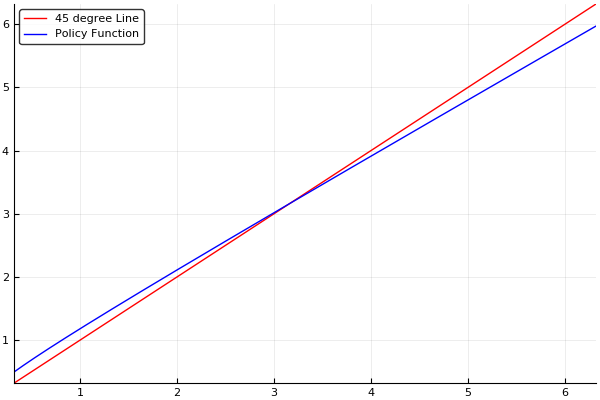

In [7]:
plot(kgrid,kgrid,color="red",label="45 degree Line")
plot!(kgrid,kpgrid,color="blue",label="Policy Function")

In [8]:
@benchmark TI(t)

BenchmarkTools.Trial: 
  memory estimate:  72.81 MiB
  allocs estimate:  3409279
  --------------
  minimum time:     399.880 ms (5.50% GC)
  median time:      429.859 ms (4.13% GC)
  mean time:        440.935 ms (4.19% GC)
  maximum time:     526.839 ms (3.86% GC)
  --------------
  samples:          12
  evals/sample:     1